In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from rasterio.plot import plotting_extent
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
from config import PLOTS_DIR
from sys import path

path.append("..")
from config import LAND_COVER_LEGEND

In [2]:
from collections import defaultdict, Counter

sequence_frame = pd.read_csv("../data/dynamicity/change_sequences.csv")

sequence_frame.dropna(inplace=True)
years = [str(i) for i in range(2016, 2024)]

In [3]:
from collections import defaultdict, Counter
import pandas as pd
import matplotlib.pyplot as plt
from sys import path

path.append("..")
from config import LAND_COVER_LEGEND

# plt.style.use("fivethirtyeight")
plt.style.use("default")

num_occurences = 1

views = defaultdict(int)
for k, row in sequence_frame.iterrows():
    vals = [row[str(year)] for year in years]
    for k, v in dict(Counter(vals)).items():
        if v == 1:
            base_idx = vals.index(k)
            key_string = "-->".join(
                [LAND_COVER_LEGEND[ks] for ks in vals[base_idx - 1 : base_idx + 2]]
            )
            views[key_string] += row["num_tiles"]

views = pd.DataFrame(
    {"category": list(views.keys()), "num_tiles": list(views.values())}
)
views = views[views["category"].str.len() > 15]
views["sqkm"] = views["num_tiles"] * 100 / 10**6

# rename sqkm to km²
views.rename(columns={"sqkm": "km²"}, inplace=True)

views = views[views["category"] != 0]

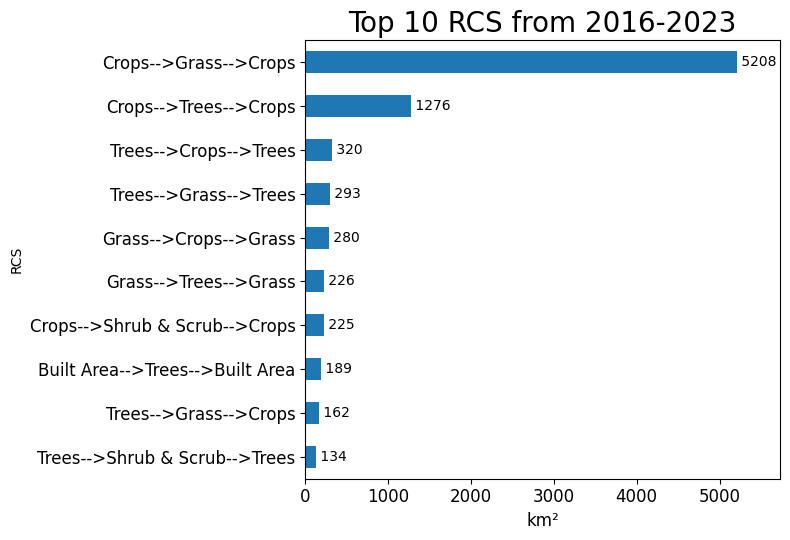

In [4]:
# # place the legend to the bottom right
# views.sort_values("num_tiles", ascending=False).head(10).sort_values(
#     "num_tiles", ascending=True
# )[["category", "km²"]].plot(
#     kind="barh",
#     x="category",
#     y="km²",
#     # figsize=[4, 4],
#     legend=False,
#     title="Top 10 rapid change sequences from 2016-2023",
# ).set_xlabel("km²")

plt.style.use("default")

sorted_views = (
    views.sort_values("num_tiles", ascending=False)
    .head(10)
    .sort_values("num_tiles", ascending=True)
)

ax = sorted_views[["category", "km²"]].plot(
    kind="barh",
    x="category",
    y="km²",
    legend=False,
    title="Top 10 rapid change sequences from 2016-2023",
    figsize=[8, 5.5],
)

# Add annotations
for index, value in enumerate(sorted_views["km²"]):
    ax.text(value, index, f" {value:.0f}", va="center")

# Set xlabel and legend position
ax.set_xlabel("km²")
# extend the xrange to make space for the legend
ax.set_xlim(0, sorted_views["km²"].max() * 1.1)
# ax.legend(loc="lower right")
ax.legend().set_visible(False)

plt.ylabel("RCS")

# increase font size of xticks, yticks and labels, title
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("km²", fontsize=12)
plt.title("Top 10 RCS from 2016-2023", fontsize=20)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "rcs" / "top_10_rcs_abs.png", bbox_inches="tight")
plt.show()

In [5]:
num_occurences = 1

views = defaultdict(int)
for k, row in sequence_frame.iterrows():
    vals = [row[str(year)] for year in years]
    for k, v in dict(Counter(vals)).items():
        if v == 1:
            views[LAND_COVER_LEGEND[k]] += row["num_tiles"]


plt.style.use("default")
views = pd.DataFrame(
    {"category": list(views.keys()), "num_tiles": list(views.values())}
)
views["km²"] = views["num_tiles"] * 100 / 10**6
views = views[views["category"] != 0]

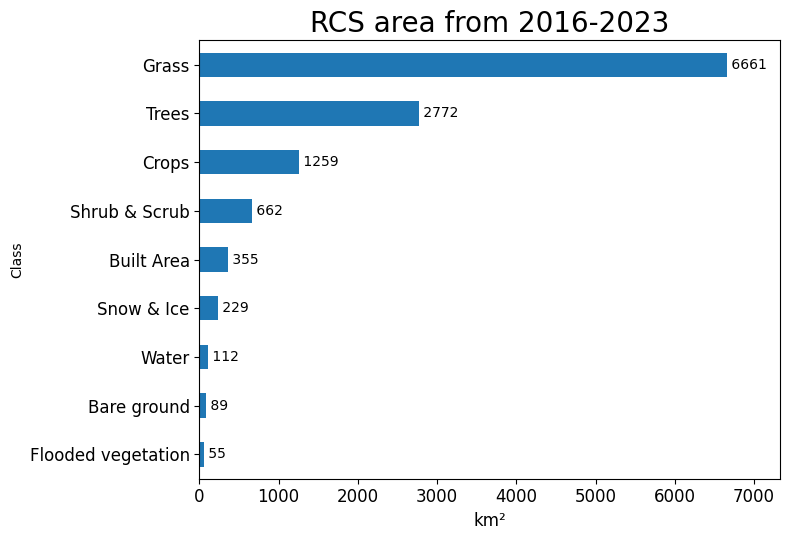

In [6]:
sorted_views = views.sort_values("num_tiles", ascending=True)

ax = sorted_views[["category", "km²"]].plot(
    kind="barh",
    x="category",
    y="km²",
    title="Rapid change sequence area from 2016-2023",
    figsize=[8, 5.5],
)

ax.set_xlabel("km²")

# Add annotations
for index, value in enumerate(sorted_views["km²"]):
    ax.text(value, index, f" {value:.0f}", va="center")

# extend the xrange to make space for the legend
ax.set_xlim(0, sorted_views["km²"].max() * 1.1)

# remove the legend
ax.legend().set_visible(False)

# rename y axis from category to Clas
plt.ylabel("Class")

# increase font size of xticks, yticks and labels, title
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("km²", fontsize=12)
plt.title("RCS area from 2016-2023", fontsize=20)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "rcs" / "rcs_area_abs.png", bbox_inches="tight")
plt.show()

In [7]:
views_total = defaultdict(int)
for k, row in sequence_frame.iterrows():
    vals = [row[str(year)] for year in years]
    for k, v in dict(Counter(vals)).items():
        if v >= 1:
            views_total[LAND_COVER_LEGEND[k]] += row["num_tiles"]

views_total = pd.DataFrame(
    {"category": list(views_total.keys()), "num_tiles": list(views_total.values())}
)

In [8]:
views

,category,num_tiles,km²
0,Trees,27722978,2772.2978
1,Grass,66605978,6660.5978
2,Flooded vegetation,549498,54.9498
3,Crops,12592413,1259.2413
4,Shrub & Scrub,6621299,662.1299
5,Built Area,3549045,354.9045
6,Bare ground,889339,88.9339
7,Snow & Ice,2293241,229.3241
8,Water,1122694,112.2694


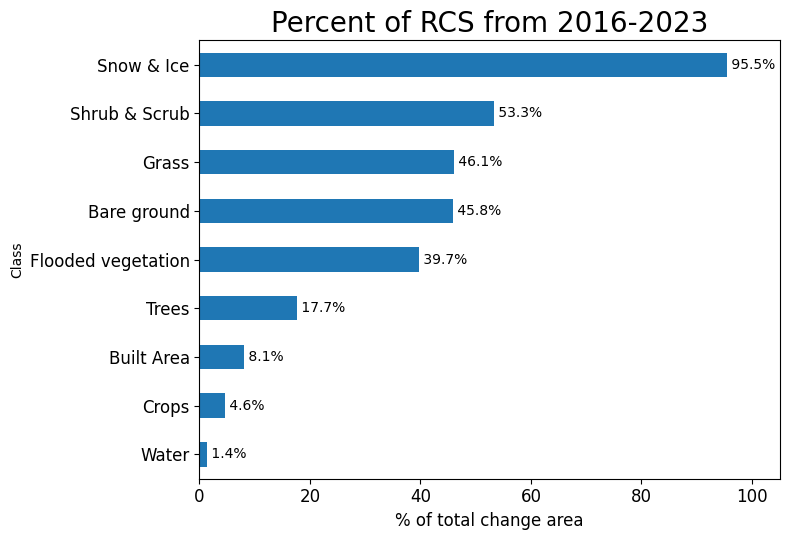

In [9]:
views_total["sqkm_total"] = views_total["num_tiles"] * 100 / 10**6
views_total.drop("num_tiles", axis=1, inplace=True)
views["sqkm"] = views["num_tiles"] * 100 / 10**6
views = views.merge(views_total, on="category")

plt.style.use("default")
views["miclassified_percentage_of_change"] = [
    round(row["sqkm"] / row["sqkm_total"] * 100, 2) for k, row in views.iterrows()
]
views = views[views["category"] != 0]

sorted_views = views.sort_values("miclassified_percentage_of_change", ascending=True)

ax = sorted_views[["category", "miclassified_percentage_of_change"]].plot(
    kind="barh",
    x="category",
    y="miclassified_percentage_of_change",
    figsize=[8, 5.5],
    title="Percent of rapid change sequences from 2016-2023",
)

ax.set_xlabel("% of total change area")

# Add annotations
for index, value in enumerate(sorted_views["miclassified_percentage_of_change"]):
    ax.text(value, index, f" {value:.1f}%", va="center")

# extend the xrange to make space for the legend
ax.set_xlim(0, sorted_views["miclassified_percentage_of_change"].max() * 1.1)

# remove the legend
ax.legend().set_visible(False)

# rename y axis from category to Class
plt.ylabel("Class")

# increase font size of xticks, yticks and labels, title
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("% of total change area", fontsize=12)
plt.title("Percent of RCS from 2016-2023", fontsize=20)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "rcs" / "rcs_area_percent.png", bbox_inches="tight")

plt.show()